# Semi-Monocoque Theory

In [1]:
from pint import UnitRegistry
import sympy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline
from IPython.display import display

Import **Section** class, which contains all calculations

In [2]:
from Section import Section

Initialization of **sympy** symbolic tool and **pint** for dimension analysis (not really implemented rn as not directly compatible with sympy)

In [3]:
ureg = UnitRegistry()
sympy.init_printing()

Define **sympy** parameters used for geometric description of sections

In [4]:
A, A0, t, t0, a, b, h, L = sympy.symbols('A A_0 t t_0 a b h L', positive=True)

We also define numerical values for each **symbol** in order to plot scaled section and perform calculations

In [5]:
values = [(A, 450 * ureg.millimeter**2),(A0, 250  * ureg.millimeter**2),(a, 130 * ureg.millimeter), \
          (b, 300 * ureg.millimeter),(h, 150 * ureg.millimeter),(L, 650 * ureg.millimeter)]
datav = [(v[0],v[1].magnitude) for v in values]

# Multiconnected Section

Define graph describing the section:

1) **stringers** are **nodes** with parameters:
- **x** coordinate
- **y** coordinate
- **Area**

2) **panels** are **oriented edges** with parameters:
- **thickness**
- **lenght** which is automatically calculated

In [6]:
stringers = {1:[(sympy.Integer(0),h),A],
             2:[(sympy.Integer(0),sympy.Integer(0)),A],
             3:[(a,sympy.Integer(0)),A],
             4:[(a+b,sympy.Integer(0)),A],
             5:[(a+b,h),A],
             6:[(a,h),A]}

panels = {(1,2):t,
          (2,3):t,
          (3,4):t,
          (4,5):t,
          (5,6):t,
          (6,1):t,
          (3,6):t}

Define section and perform first calculations

In [7]:
S3 = Section(stringers, panels)

As we need to compute $x_{sc}$, we have to perform

$$A \cdot q_{ext} = T$$

where:
- **A** is a matrix with **number of nodes + number of loops** rows and **number of edges +1** columns (it is square)
- **q** is a column vector of unknowns: **#edges fluxes** and **shear center** coordinate
- **T** is the vector of known terms: $-\frac{T_y}{J_x} \cdot S_{x_i}$ or $-\frac{T_x}{J_y} \cdot S_{y_i}$ for *n-1* nodes and the rest are 0

**Expression of A**

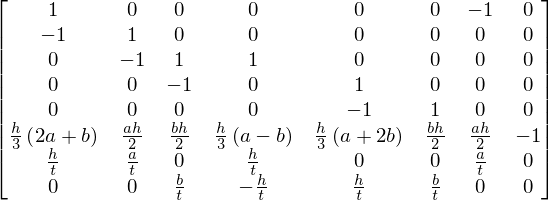

In [8]:
sympy.simplify(S3.A)

**Expression of T**

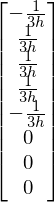

In [9]:
sympy.simplify(S3.T)

**Resulting fluxes and coordinate**

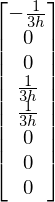

In [10]:
sympy.simplify(S3.tempq)

## Plot of **S3** section in original reference frame

In [11]:
start_pos={ii: [float(S3.g.node[ii]['ip'][i].subs(datav)) for i in range(2)] for ii in S3.g.nodes() }

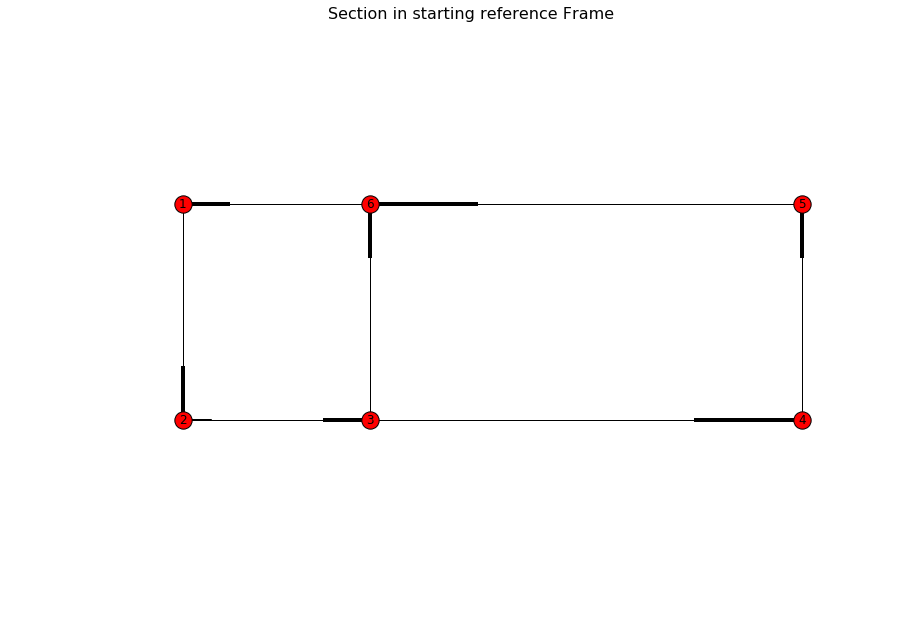

In [12]:
plt.figure(figsize=(12,8),dpi=300)
nx.draw(S3.g,with_labels=True, arrows= True, pos=start_pos)
plt.arrow(0,0,20,0)
plt.arrow(0,0,0,20)
#plt.text(0,0, 'CG', fontsize=24)
plt.axis('equal')
plt.title("Section in starting reference Frame",fontsize=16);

Expression of **Inertial properties** wrt Center of Gravity in with original rotation

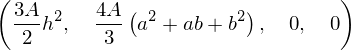

In [13]:
S3.Ixx0, S3.Iyy0, S3.Ixy0, S3.α0

## Plot of **S3** section in inertial reference Frame

Section is plotted wrt **center of gravity** and rotated (if necessary) so that *x* and *y* are principal axes.
**Center of Gravity** and **Shear Center** are drawn

In [14]:
positions={ii: [float(S3.g.node[ii]['pos'][i].subs(datav)) for i in range(2)] for ii in S3.g.nodes() }

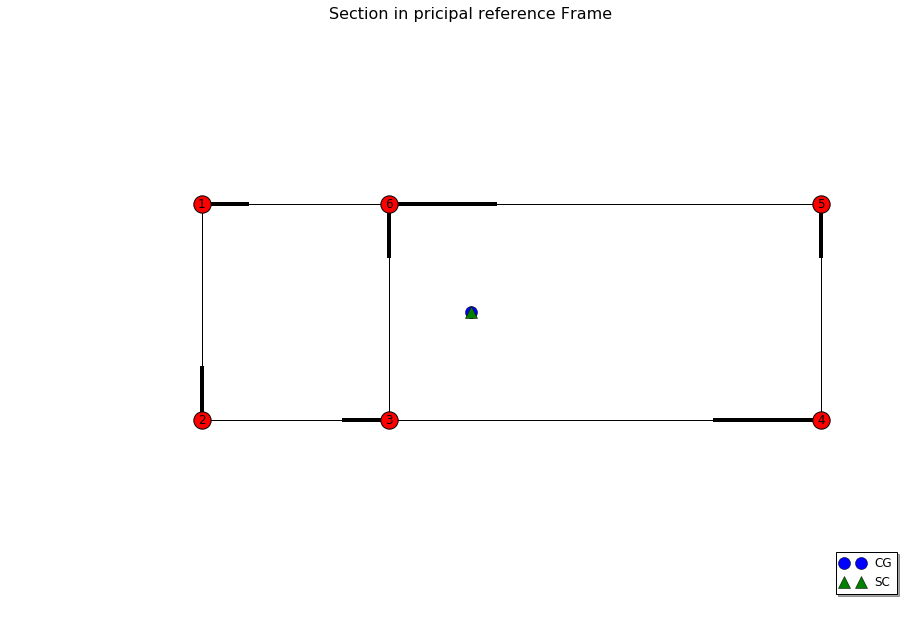

In [15]:
x_ct, y_ct = S3.ct.subs(datav)

plt.figure(figsize=(12,8),dpi=300)
nx.draw(S3.g,with_labels=True, pos=positions)
plt.plot([0],[0],'o',ms=12,label='CG')
plt.plot([x_ct],[y_ct],'^',ms=12, label='SC')
#plt.text(0,0, 'CG', fontsize=24)
#plt.text(x_ct,y_ct, 'SC', fontsize=24)
plt.legend(loc='lower right', shadow=True)
plt.axis('equal')
plt.title("Section in pricipal reference Frame",fontsize=16);

Expression of **inertial properties** in *principal reference frame*

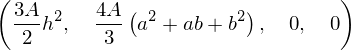

In [16]:
S3.Ixx, S3.Iyy, S3.Ixy, S3.θ

## **Shear center** expression 

In [17]:
S3.ct

## Loops detection

In [18]:
S3.cycles

## Compute axial loads in Stringers in **S3**

Set **loads** on the section:

**Example 1**: _shear_ in **y** direction and _bending moment_ in **x** direction

In [19]:
Tx, Ty, Nz, Mx, My, Mz, F, ry, ry, mz = sympy.symbols('T_x T_y N_z M_x M_y M_z F r_y r_x m_z')
S3.set_loads(_Tx=0, _Ty=Ty, _Nz=0, _Mx=Mx, _My=0, _Mz=0)

Compute _axial loads_ in **stringers** and _shear flows_ in **panels**

In [20]:
S3.compute_stringer_actions()
S3.compute_panel_fluxes();

Expression of matrix **A**:

- second to last row: Mz equilibrium
- last row: equivalence of rotations in the form: $\dot{\theta_1} - \dot{\theta_2} = 0$

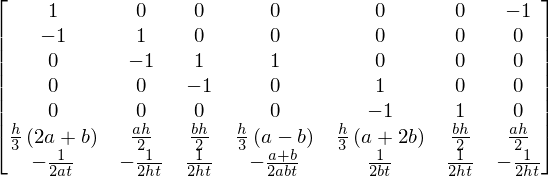

In [21]:
sympy.simplify(S3.A)

Expression of **T**

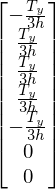

In [22]:
sympy.simplify(S3.T)

## Axial loads

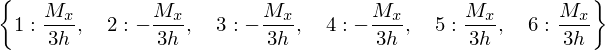

In [23]:
S3.N

## Shear flows

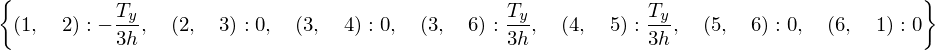

In [24]:
sympy.simplify(S3.q)

**Example 2**: _twisting moment_ in **z** direction

In [25]:
S3.set_loads(_Tx=0, _Ty=0, _Nz=0, _Mx=0, _My=0, _Mz=Mz)
S3.compute_stringer_actions()
S3.compute_panel_fluxes();

In [26]:
S3.N

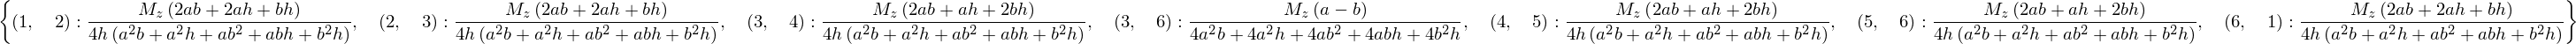

In [27]:
S3.q

Set **loads** on the section:

**Example 3**: _shear_ in **x** direction and _bending moment_ in **y** direction

In [28]:
S3.set_loads(_Tx=Tx, _Ty=0, _Nz=0, _Mx=0, _My=My, _Mz=0)
S3.compute_stringer_actions()
S3.compute_panel_fluxes();

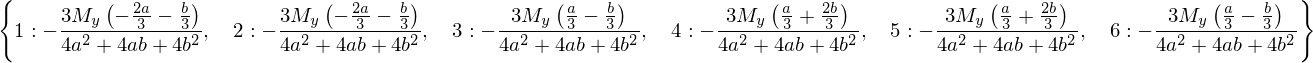

In [29]:
S3.N

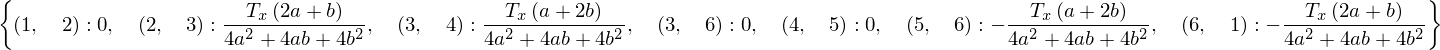

In [30]:
S3.q

Verify that $$q_i \cdot l_i = T_x$$

In [31]:
sympy.simplify(S3.q[(2,3)]*a+S3.q[(3,4)]*b-S3.q[(5,6)]*b-S3.q[(6,1)]*a)

## Torsional moment of inertia

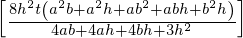

In [32]:
S3.compute_Jt()
S3.Jt